In [1]:
import pandas as pd

ratings = pd.read_csv(
    "ml-100k/u.data",
    sep="\t",
    names=["user_id", "movie_id", "rating", "timestamp"]
)

ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [2]:
ratings.shape

(100000, 4)

In [3]:
ratings["user_id"].nunique(), ratings["movie_id"].nunique() # different user IDs exist

(943, 1682)

# Exploratory Data Analysis (EDA)

### Rating distribution

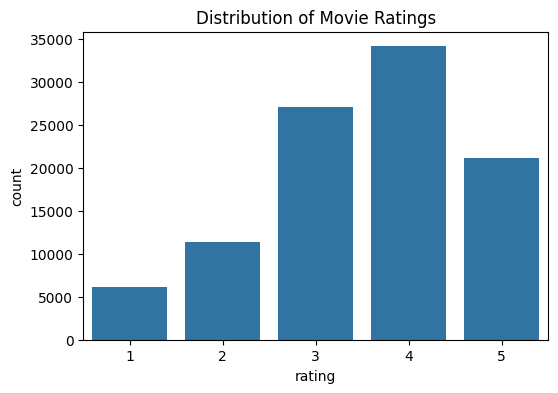

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6,4))
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of Movie Ratings")
plt.show()

### Ratings per User

In [5]:
user_activity = ratings.groupby("user_id")["rating"].count()

user_activity.describe()

count    943.000000
mean     106.044539
std      100.931743
min       20.000000
25%       33.000000
50%       65.000000
75%      148.000000
max      737.000000
Name: rating, dtype: float64

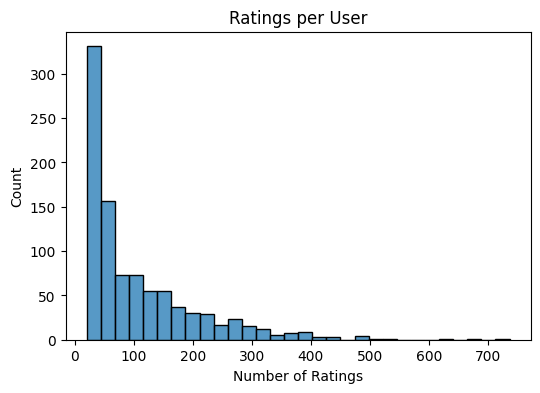

In [6]:
plt.figure(figsize=(6,4))
sns.histplot(user_activity, bins=30)
plt.title("Ratings per User")
plt.xlabel("Number of Ratings")
plt.show()

### Ratings per movie

In [7]:
movie_popularity = ratings.groupby("movie_id")["rating"].count()

movie_popularity.describe()

count    1682.000000
mean       59.453032
std        80.383846
min         1.000000
25%         6.000000
50%        27.000000
75%        80.000000
max       583.000000
Name: rating, dtype: float64

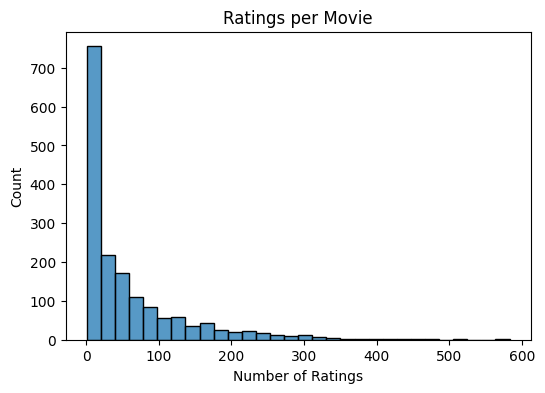

In [8]:
plt.figure(figsize=(6,4))
sns.histplot(movie_popularity, bins=30)
plt.title("Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.show()

### How sparse is the user-movie matrix?

In [9]:
n_users = ratings["user_id"].nunique()
n_movies = ratings["movie_id"].nunique()
n_ratings = len(ratings)

total_possible = n_users * n_movies

sparsity = 1 - (n_ratings / total_possible)

print("Users:", n_users)
print("Movies:", n_movies)
print("Ratings:", n_ratings)
print("total_possible:", total_possible)
print("sparsity:", sparsity)

print("Sparsity:", round(sparsity*100, 2), "%")

Users: 943
Movies: 1682
Ratings: 100000
total_possible: 1586126
sparsity: 0.9369533063577546
Sparsity: 93.7 %


### Top Popular Movies (Baseline Insight)

In [10]:
top_movies = movie_popularity.sort_values(ascending=False).head(10)
top_movies

movie_id
50     583
258    509
100    508
181    507
294    485
286    481
288    478
1      452
300    431
121    429
Name: rating, dtype: int64

# Baseline Popularity-Based Recommender

### Add Movie Titles 

In [11]:
movies = pd.read_csv(
    "ml-100k/u.item",
    sep="|",
    encoding="latin-1",
    header=None,
    usecols=[0, 1],
    names=["movie_id", "title"]
)

movies.head()

,movie_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)
2,3,Four Rooms (1995)
3,4,Get Shorty (1995)
4,5,Copycat (1995)


### Merge ratings with movie titles

In [12]:
ratings_with_titles = ratings.merge(movies, on="movie_id")
ratings_with_titles

,user_id,movie_id,rating,timestamp,title
0,196,242,3,881250949,Kolya (1996)
1,186,302,3,891717742,L.A. Confidential (1997)
2,22,377,1,878887116,Heavyweights (1994)
3,244,51,2,880606923,Legends of the Fall (1994)
4,166,346,1,886397596,Jackie Brown (1997)
...,...,...,...,...,...
99995,880,476,3,880175444,"First Wives Club, The (1996)"
99996,716,204,5,879795543,Back to the Future (1985)
99997,276,1090,1,874795795,Sliver (1993)
99998,13,225,2,882399156,101 Dalmatians (1996)


### Compute movie statistics 
- average rating
- number of rating

In [13]:
movie_stats = ratings_with_titles.groupby("title").agg(
    avg_rating=("rating", "mean"),
    rating_count=("rating", "count")
).reset_index()

movie_stats.head()

,title,avg_rating,rating_count
0,'Til There Was You (1997),2.333333,9
1,1-900 (1994),2.600000,5
2,101 Dalmatians (1996),2.908257,109
3,12 Angry Men (1957),4.344000,125
4,187 (1997),3.024390,41


### Filter for polular movies

In [14]:
popular_movies = movie_stats[movie_stats["rating_count"] >= 50]

### Top popular movies to recommend

In [15]:
top_popular = popular_movies.sort_values(
    by="avg_rating",
    ascending=False
).head(10)

top_popular

,title,avg_rating,rating_count
318,"Close Shave, A (1995)",4.491071,112
1281,Schindler's List (1993),4.466443,298
1652,"Wrong Trousers, The (1993)",4.466102,118
273,Casablanca (1942),4.456790,243
1597,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1317,"Shawshank Redemption, The (1994)",4.445230,283
1215,Rear Window (1954),4.387560,209
1572,"Usual Suspects, The (1995)",4.385768,267
1398,Star Wars (1977),4.358491,583
3,12 Angry Men (1957),4.344000,125


### Function to recommend popular movies

In [17]:
def recommend_polular(n=10):
    return top_popular[["title", "avg_rating", "rating_count"]].head(n)

#test
recommend_polular(10)

,title,avg_rating,rating_count
318,"Close Shave, A (1995)",4.491071,112
1281,Schindler's List (1993),4.466443,298
1652,"Wrong Trousers, The (1993)",4.466102,118
273,Casablanca (1942),4.456790,243
1597,Wallace & Gromit: The Best of Aardman Animatio...,4.447761,67
1317,"Shawshank Redemption, The (1994)",4.445230,283
1215,Rear Window (1954),4.387560,209
1572,"Usual Suspects, The (1995)",4.385768,267
1398,Star Wars (1977),4.358491,583
3,12 Angry Men (1957),4.344000,125


# User-Based Collaborative Filtering

### Create user-movie matrix

In [18]:
# Pivot table
user_movie_matrix=ratings.pivot_table(
    index="user_id",
    columns="movie_id",
    values="rating"
)

user_movie_matrix.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Fill missing values

In [19]:
user_movie_filled=user_movie_matrix.fillna(0)
user_movie_filled.head()

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,4.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute user similarity(cosine similarity)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(user_movie_filled)
user_similarity.shape

(943, 943)

### Find similar users

In [21]:
user_similarity_df = pd.DataFrame(
    user_similarity,
    index=user_movie_filled.index,
    columns=user_movie_filled.index
)

user_similarity_df.loc[1].sort_values(ascending=False).head(10)

user_id
1      1.000000
916    0.569066
864    0.547548
268    0.542077
92     0.540534
435    0.538665
457    0.538476
738    0.527031
429    0.525950
303    0.525718
Name: 1, dtype: float64

### Helper: Movies user already rated

In [22]:
def get_user_seen_movies(user_id):
    return ratings[ratings["user_id"] == user_id]["movie_id"].tolist()

### Recommendation Function

In [23]:
def recommend_user_based(user_id, n_recommendations=10):
    # similar users (excluding self)
    similar_users = user_similarity_df[user_id].sort_values(ascending=False)[1:11]

    # movies seen by target user
    seen_movies = set(get_user_seen_movies(user_id))

    # collect ratings from similar users
    similar_users_ids = similar_users.index

    recs = ratings[ratings["user_id"].isin(similar_users_ids)]

    # remove already seen movies
    recs = recs[~recs["movie_id"].isin(seen_movies)]

    # average rating among similar users
    movie_scores = recs.groupby("movie_id")["rating"].mean()

    # top recommendations
    top_movies = movie_scores.sort_values(ascending=False).head(n_recommendations)
    
    return top_movies

In [24]:
recommend_user_based(5)

movie_id
945     5.0
1206    5.0
500     5.0
582     5.0
1500    5.0
236     5.0
654     5.0
246     5.0
321     5.0
724     5.0
Name: rating, dtype: float64

In [28]:
# with titles
def recommend_with_titles(user_id, n=10):
    top_series = recommend_user_based(user_id, n)  # movie_id -> score
    rec_df = top_series.reset_index()
    rec_df.columns = ["movie_id", "score"]
    
    rec_df = rec_df.merge(movies, on="movie_id", how="left")
    return rec_df[["movie_id", "title", "score"]]

recommend_with_titles(5, 10)

,movie_id,title,score
0,945,Charade (1963),5.0
1,1206,Amos & Andrew (1993),5.0
2,500,Fly Away Home (1996),5.0
3,582,"Piano, The (1993)",5.0
4,1500,Santa with Muscles (1996),5.0
5,236,Citizen Ruth (1996),5.0
6,654,Chinatown (1974),5.0
7,246,Chasing Amy (1997),5.0
8,321,Mother (1996),5.0
9,724,Circle of Friends (1995),5.0


- recommend_user_based() = IDs + scores
- recommend_with_titles() = IDs + titles
- isin() may change order → merge with scores to keep ranking

# Item-Based Collaborative Filtering

### Create Movie–User Matrix

In [29]:
movie_user_matrix = user_movie_filled.T  # Transpose
movie_user_matrix.head()

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
movie_id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
2,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
5,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Compute Movie Similarity

In [30]:
movie_similarity = cosine_similarity(movie_user_matrix)

movie_similarity.shape

(1682, 1682)

In [31]:
# Convert to DataFrame

movie_similarity_df = pd.DataFrame(
    movie_similarity,
    index=movie_user_matrix.index,
    columns=movie_user_matrix.index
)

### Find Similar Movies to a Given Movie

In [32]:
movie_similarity_df.loc[50].sort_values(ascending=False).head(10)

movie_id
50     1.000000
181    0.884476
174    0.764885
172    0.749819
1      0.734572
127    0.697332
121    0.692837
210    0.689343
100    0.686533
98     0.676428
Name: 50, dtype: float64

In [33]:
# Show movie title
movies[movies["movie_id"] == 50]

,movie_id,title
49,50,Star Wars (1977)


### Recommend Movies Based on Liked Movies

In [34]:
# Movies user rated highly

def get_user_favorites(user_id, min_rating=4):
    return ratings[
        (ratings["user_id"] == user_id) & (ratings["rating"] >= min_rating)
    ]["movie_id"].tolist()

In [35]:
# Item-Based Recommendation Function

def recommend_item_based(user_id, n_recommendations=10):
    
    favorite_movies = get_user_favorites(user_id)
    scores = pd.Series(dtype=float)
    
    for movie_id in favorite_movies:
        similar_scores = movie_similarity_df[movie_id]
        scores = scores.add(similar_scores, fill_value=0)
    
    # remove already seen movies
    seen_movies = get_user_seen_movies(user_id)
    scores = scores.drop(index=seen_movies, errors="ignore")
    
    # top recommendations
    top_movies = scores.sort_values(ascending=False).head(n_recommendations)
    
    return top_movies

In [36]:
def recommend_item_titles(user_id, n=10):
    rec_ids = recommend_item_based(user_id, n).index
    return movies[movies["movie_id"].isin(rec_ids)]

recommend_item_titles(5, 10)

,movie_id,title
27,28,Apollo 13 (1995)
55,56,Pulp Fiction (1994)
81,82,Jurassic Park (1993)
95,96,Terminator 2: Judgment Day (1991)
160,161,Top Gun (1986)
194,195,"Terminator, The (1984)"
195,196,Dead Poets Society (1989)
201,202,Groundhog Day (1993)
237,238,Raising Arizona (1987)
567,568,Speed (1994)


# Matrix Factorization (SVD)

In [40]:
user_means = user_movie_filled.mean(axis=1)
R_demeaned = user_movie_filled.sub(user_means, axis=0)

### Apply SVD

In [41]:
import numpy as np

U, sigma, Vt = np.linalg.svd(R_demeaned, full_matrices=False)

### Keep only top K factors

In [43]:
k=20

U_k = U[:,:k]
sigma_k = np.diag(sigma[:k])
Vt_k = Vt[:k, :]

### Reconstruct predicted ratings

In [47]:
R_pred = np.dot(np.dot(U_k, sigma_k), Vt_k)

R_pred_df = pd.DataFrame(
    R_pred,
    index=user_movie_filled.index,
    columns=user_movie_filled.columns
)

R_pred_df = R_pred_df.add(user_means, axis=0)

movie_id,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
user_id,,,,,,,,,,,,,,,,,,,,,
1,4.072775,2.075313,1.384202,3.299866,0.553462,0.626354,4.691949,2.672352,3.123433,1.983521,...,0.006805,0.036114,0.031001,0.028518,0.047826,0.021612,0.017733,0.019672,0.049315,0.096311
2,1.994956,-0.005914,-0.005042,0.306789,0.027157,0.306275,1.588519,0.489860,2.534156,0.634309,...,-0.019560,-0.039974,-0.023257,-0.021914,-0.019828,-0.014365,-0.004637,-0.009501,-0.021962,-0.048732
3,-0.179277,-0.075473,0.186076,-0.138467,-0.133028,0.034548,-0.209580,0.001435,-0.398286,0.016849,...,0.013940,-0.001084,0.026703,0.020681,0.008151,0.019197,0.040318,0.029758,0.010335,0.008857
4,0.528281,-0.188725,0.098394,-0.149524,0.045827,0.026983,0.371855,-0.186562,-0.086079,-0.172710,...,0.023667,0.011204,0.010476,0.013859,0.017121,0.026071,0.036962,0.031517,0.017568,0.022447
5,3.700538,1.221118,0.353461,1.657660,0.454890,-0.105930,2.934491,1.180798,-0.393456,0.311036,...,0.044259,0.059503,0.020381,0.031819,0.038400,0.053367,0.050712,0.052039,0.051519,0.036065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,2.514283,-0.017255,0.100699,0.047937,0.417070,0.007956,1.383524,0.505193,1.707299,0.112078,...,0.029323,0.041773,0.041235,0.035981,0.033796,0.019997,0.009045,0.014521,0.024784,0.015323
940,2.068035,0.332470,-0.232480,1.956268,0.572573,-0.000464,2.474521,1.657103,1.506022,-0.127236,...,-0.028325,-0.003289,-0.035677,-0.032976,-0.032387,-0.020556,-0.006521,-0.013539,-0.038809,-0.053804
941,2.252711,0.045003,0.272690,0.064183,-0.029935,-0.005652,1.796847,0.468350,0.895766,0.135172,...,-0.008462,-0.005959,-0.008001,-0.004195,0.008629,0.000788,-0.004471,-0.001841,0.014217,-0.000954


### Recommend Movies Using SVD

In [48]:
def recommend_svd(user_id, n=10):
    user_ratings = R_pred_df.loc[user_id]

    seen_movies = get_user_seen_movies(user_id)
    user_ratings = user_ratings.drop(index=seen_movies, errors="ignore")

    top_movies = user_ratings.sort_values(ascending=False).head(n)

    return movies[movies["movie_id"].isin(top_movies.index)]

In [49]:
recommend_svd(5, 10)

,movie_id,title
6,7,Twelve Monkeys (1995)
81,82,Jurassic Park (1993)
87,88,Sleepless in Seattle (1993)
90,91,"Nightmare Before Christmas, The (1993)"
174,175,Brazil (1985)
194,195,"Terminator, The (1984)"
201,202,Groundhog Day (1993)
237,238,Raising Arizona (1987)
257,258,Contact (1997)
473,474,Dr. Strangelove or: How I Learned to Stop Worr...
